# Семинар №7.

1. Кросс-валидация
2. GridSearchCV
3. hyperopt

## Кросс-валидация

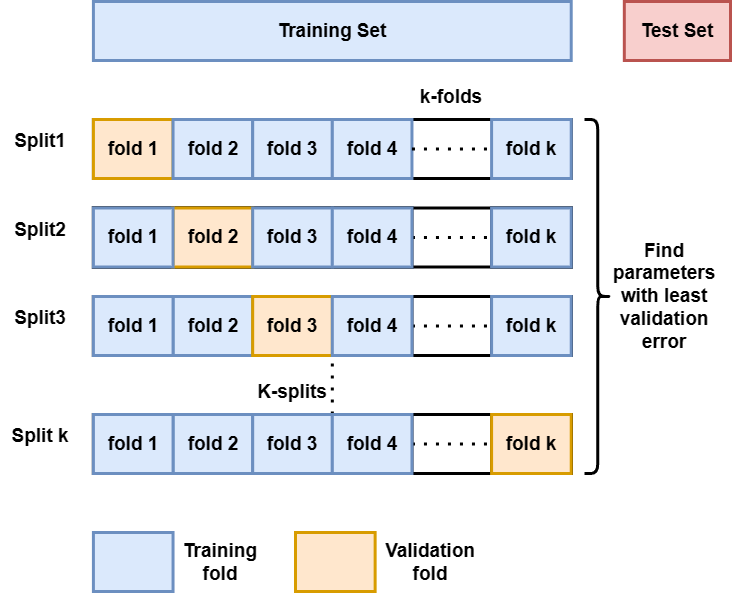

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
data = pd.read_csv("house_price_regression_dataset.csv")
data

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06
...,...,...,...,...,...,...,...,...
995,3261,4,1,1978,2.165110,2,10,7.014940e+05
996,3179,1,2,1999,2.977123,1,10,6.837232e+05
997,2606,4,2,1962,4.055067,0,2,5.720240e+05
998,4723,5,2,1950,1.930921,0,7,9.648653e+05


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Square_Footage        1000 non-null   int64  
 1   Num_Bedrooms          1000 non-null   int64  
 2   Num_Bathrooms         1000 non-null   int64  
 3   Year_Built            1000 non-null   int64  
 4   Lot_Size              1000 non-null   float64
 5   Garage_Size           1000 non-null   int64  
 6   Neighborhood_Quality  1000 non-null   int64  
 7   House_Price           1000 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 62.6 KB


In [4]:
X = data.drop(columns=["House_Price"])
y = data["House_Price"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)
y_train = y_train.reset_index()["House_Price"]
y_test = y_test.reset_index()["House_Price"]

In [6]:
model = RandomForestRegressor(n_estimators=1, max_depth=300, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

27546.853436741025

In [7]:
model = RandomForestRegressor(n_estimators=200, max_depth=10, n_jobs=-1)

In [8]:
cv_res = cross_val_score(model, X_train, y_train, cv=10, scoring="neg_mean_absolute_error", n_jobs=-1)
cv_res.mean()

np.float64(-18151.867844539327)

In [9]:
train_idx = np.random.choice(X_train.shape[0], size=int(0.9 * X_train.shape[0]), replace=False)

In [17]:
model.fit(X_train.loc[train_idx], y_train[train_idx])
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

17171.416106416895

## GridSearchCV

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [1, 10, 30, 100],
    "max_depth": [3, 7, 11, 15, 30],
    "min_samples_split": [2, 5, 10, 50],
    "min_samples_leaf": [1, 5, 10, 50],
}
grid_search = GridSearchCV(model, param_grid, cv=10, n_jobs=-1)

In [19]:
%%time
grid_search.fit(X_train, y_train)

CPU times: user 1min 9s, sys: 9.01 s, total: 1min 18s
Wall time: 1min 33s


,estimator,"RandomForestR...00, n_jobs=-1)"
,param_grid,"{'max_depth': [3, 7, ...], 'min_samples_leaf': [1, 5, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [1, 10, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [20]:
y_pred = grid_search.predict(X_test)
mean_absolute_error(y_test, y_pred)

17451.01390349589

In [21]:
grid_search.best_params_

{'max_depth': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

## hyperopt

- Документация: <https://github.com/hyperopt/hyperopt/wiki/FMin>

In [23]:
from hyperopt import hp, fmin, tpe, space_eval

/home/vvh413/dev/hse/dsml2025/.venv/lib/python3.13/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [24]:
def get_best_params_for_model(model, space_params, evals=333):
    def get_model_score(params):
        clf = model(**params)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        return mean_absolute_error(y_test, y_pred)

    best = fmin(fn=get_model_score, space=space_params, algo=tpe.suggest, max_evals=evals)
    return space_eval(space_params, best)

In [25]:
random_forest_params = {
    'max_depth': hp.choice('max_depth', np.arange(1, 50, 2)),
    'n_estimators': hp.choice('n_estimators', np.arange(10, 500, 10)),
    'max_features': hp.choice('max_features', ["sqrt", "log2", None]),
    'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 30, 1)),
    'min_samples_split': hp.choice('min_samples_split', np.arange(2, 30, 1)),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', [None] + list(range(10000, 20000, 1000))),
    'n_jobs': -1
}

In [26]:
best_random_forest_params = get_best_params_for_model(RandomForestRegressor, random_forest_params, 150)

100%|██████████████████| 150/150 [00:42<00:00,  3.55trial/s, best loss: 16935.94212170173]


In [27]:
best_random_forest_params

{'max_depth': np.int64(39),
 'max_features': None,
 'max_leaf_nodes': 16000,
 'min_samples_leaf': np.int64(2),
 'min_samples_split': np.int64(4),
 'n_estimators': np.int64(360),
 'n_jobs': -1}

In [28]:
model = RandomForestRegressor(**best_random_forest_params)

In [29]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

17092.549288485734